In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2

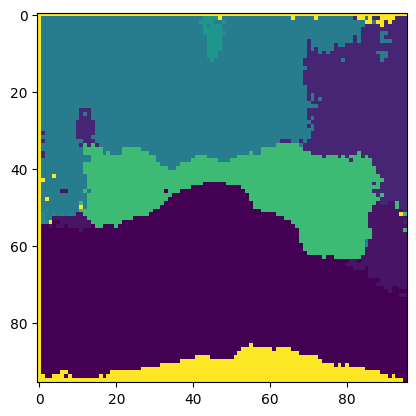

In [18]:
#modell
#create different operations of the network opearations of the network
'''
First is the single convolution layer.
convulution->batch_norm->relu
'''
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)
        self.bn = nn.BatchNorm2d(out_ch,momentum = 0.1)
        self.relu = nn.ReLU()
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
'''
Second is the maxpool with indicies
'''
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # use nn.MaxPool2d( )        
    def forward(self, x):
        x1,idx = self.down(x)
        return x1,idx

'''
Third is the unpool layer
'''
class un_pool(nn.Module):
    def __init__(self):
        super(un_pool, self).__init__()       
        self.un_pool = nn.MaxUnpool2d(kernel_size=2, stride=2) # use nn.Upsample() with mode bilinear
        
    
    def forward(self, x, idx,x1):
        #Take the indicies from maxpool layer
        x = self.un_pool(x,idx,output_size = x1.size())
        return x 
'''
Last layer is just convolution layer so we just dust define convoulution
for outlayer
'''
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)

    def forward(self, x):
        # Forward conv layer
        x = self.conv(x)
        return x

# use all above the individual operations to build the network 
class SegNet(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(SegNet, self).__init__()
        self.conv1 = single_conv(n_channels_in,64)
        self.conv2 = single_conv(64,64)
        self.down1 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv3 = single_conv(64,128)
        self.conv4 = single_conv(128,128)
        self.down2 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv5 = single_conv(128,256)
        self.conv6 = single_conv(256,256)
        self.conv7 = single_conv(256,256)
        self.down3 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv8 = single_conv(256,512)
        self.conv9 = single_conv(512,512)
        self.conv10 = single_conv(512,512)
        self.down4 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv11 = single_conv(512,512)
        self.conv12 = single_conv(512,512)
        self.conv13 = single_conv(512,512)
        self.down5 = down_layer()
        self.up1 = un_pool()
        self.conv14 = single_conv(512,512)
        self.conv15 = single_conv(512,512)
        self.conv16 = single_conv(512,512)
        self.up2 = un_pool()
        self.conv17 = single_conv(512,512)
        self.conv18 = single_conv(512,512)
        self.conv19 = single_conv(512,256)
        self.up3 = un_pool()
        self.conv20 = single_conv(256,256)
        self.conv21 = single_conv(256,256)
        self.conv22 = single_conv(256,128)
        self.up4 = un_pool()
        self.conv23 = single_conv(128,128)
        self.conv24 = single_conv(128,64)
        self.up5 = un_pool()
        self.conv25 = single_conv(64,64)
        self.outconv1 = outconv(64,n_classes)

    def forward(self, x):
        # Define forward pass
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3,idx1 = self.down1(x2) # skip connection <-------------------------
        x4 = self.conv3(x3)#                                                |
        x5 = self.conv4(x4)#                                                |
        x6,idx2 = self.down2(x5)# skip connection <-------------------      |
        x7 = self.conv5(x6)#                                         |      |
        x8 = self.conv6(x7)#                                         |      |
        x9 = self.conv7(x8)#                                         |      |
        x10,idx3 = self.down3(x9)# skip connection <-----------      |      |
        x11 = self.conv8(x10)#                                |      |      |
        x12 = self.conv9(x11)#                                |      |      | 
        x13 = self.conv10(x12)#                               |      |      |
        x14,idx4 = self.down4(x13)# skip connection <---      |      |      |
        x15 = self.conv11(x14)#                        |      |      |      |
        x16 = self.conv12(x15)#                        |      |      |      |
        x17 = self.conv13(x16)#                        |      |      |      |
        x18,idx5 = self.down5(x17)#                    |      |      |      |
        x19 = self.up1(x18,idx5,x17)#                  |      |      |      |
        x20 = self.conv14(x19)#                        |      |      |      |
        x21 = self.conv15(x20)#                        |      |      |      |
        x22 = self.conv16(x21)#                        |      |      |      |
        x23 = self.up2(x22,idx4,x13)# skip connection <-      |      |      |
        x24 = self.conv17(x23)#                               |      |      |
        x25 = self.conv18(x24)#                               |      |      |
        x26 = self.conv19(x25)#                               |      |      |
        x27 = self.up3(x26,idx3,x9)# skip connection <---------      |      |
        x28 = self.conv20(x27)#                                      |      |
        x29 = self.conv21(x28)#                                      |      |
        x30 = self.conv22(x29)#                                      |      |
        x31 = self.up4(x30,idx2,x5)# skip connection <----------------      |                                
        x32 = self.conv23(x31)#                                             |
        x33 = self.conv24(x32)#                                             |
        x34 = self.up4(x33,idx1,x2)# skip connection <-----------------------
        x35 = self.conv25(x34)
        x = self.outconv1(x35)
        ## Go up back to original dimension
        return x    
    
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def predict_segmentation(image_path, net, device):
  # Load image
  image = cv2.imread(image_path)

  # resize and normalize as in your training
  image = cv2.resize(image, (96, 96)) 
  image = image / 255.0
  image = np.transpose(image, (2, 0, 1))
  image = np.expand_dims(image, 0)
  
  # Convert to tensor
  image_tensor = torch.Tensor(image)

  # Use Model to predict
  image_tensor = image_tensor.to(device)
  net.eval()
  with torch.no_grad():
     output = net(image_tensor)
  _, predicted_segmentation = torch.max(output.data, 1) 
  return predicted_segmentation 


# Loading model
model = SegNet(3,20) #one additional class for pixel ignored

#load the best model
model_path = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/unet/net_epoch4.pth"
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Predict Segmentation
image_path = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/predict/images/image_3_test.jpg"
predicted_segmentation = predict_segmentation(image_path, model, device)

# Visualize segmentation
plt.imshow(predicted_segmentation.squeeze().cpu().numpy())
plt.show()

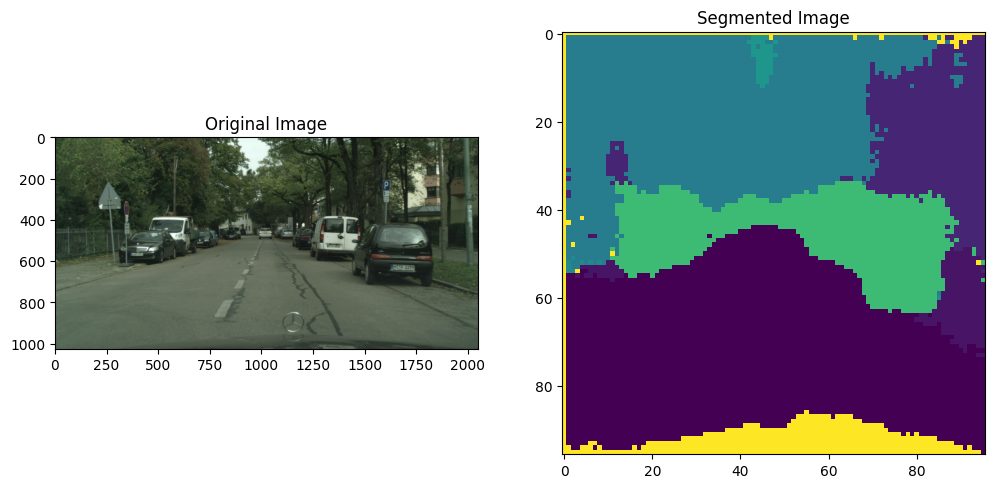

In [19]:
# Load actual image
real_image = cv2.imread(image_path)
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format by default

# Visualize actual image and segmentation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Show actual image
ax[0].imshow(real_image)
ax[0].set_title('Original Image')

# Show segmentation
ax[1].imshow(predicted_segmentation.squeeze().cpu().numpy())
ax[1].set_title('Segmented Image')

plt.show()


In [ ]:
import glob

#loading training and validation datasets, test dataset doesn't have annotations so we will use split traning data into train and test data
train_label_data_path  = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/cityscapes/gtFine/train"
train_labels = sorted(glob.glob(train_label_data_path+"/*/*_labelIds.png"))

valid_label_data_path  = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/cityscapes/gtFine/val"
valid_labels = sorted(glob.glob(valid_label_data_path+"/*/*_labelIds.png"))

train_img_path  = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/cityscapes/leftImg8bit/train"
train_inp = sorted(glob.glob(train_img_path+"/*/*.png"))

valid_img_path  = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/cityscapes/leftImg8bit/val"
valid_inp = sorted(glob.glob(valid_img_path+"/*/*.png"))

def split_dataset (train_inp, train_labels, valid_inp, valid_labels):
  train = []
  for x in zip(train_inp,train_labels):
    train.append(x)
  valid_dataset =[]
  for x in zip(valid_inp,valid_labels):
    valid_dataset.append(x)

  n =  len(train)
  train_n = int(0.8*n) 
  np.random.seed(0)
  perm = np.random.permutation(n)
  train_dataset = []
  test_dataset = []
  for i in range(len(perm[0:train_n])):   
    train_dataset.append(train[perm[i]])
  for i in range(len(perm[train_n:n])):
    test_dataset.append(train[perm[i]]) 
  
  return train_dataset, valid_dataset, test_dataset

train_dataset, valid_dataset, test_dataset = split_dataset(train_inp, train_labels, valid_inp, valid_labels)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size=128, 
                                            shuffle=True, 
                                            num_workers=0)

#function to convert labelids to trainids
def createtrainID(label_in ,label_dic):
  mask = np.zeros((label_in.shape[0],label_in.shape[1]))
  l_un = np.unique(label_in)
  for i in range(len(l_un)):
    mask[label_in==l_un[i]] = label_dic[l_un[i]] 
  return mask

#function to generate images for training, validation and testing
def gen_mask_train(x,label_dic,s1=96,s2=96):
  #s1,s2,_ = cv2.imread(x[0]).shape
  mask = np.zeros((len(x),s1,s2))
  for i in range(len(x)):
      image = createtrainID(cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)[:,:,0],label_dic)
      mask[i,:,:] = image
      mask[mask==255] = 19
  return torch.tensor(mask)

#function to generate images for training, validation and testing
def gen_images(x,s1=96,s2=96):
  _,_,s3 = cv2.imread(x[0]).shape
  img = np.zeros((len(x),s1,s2,s3))
  for i in range(len(x)):
      image= cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)
      image = image/255
      img[i,:,:,:] = image
  return torch.tensor(img).permute(0,3,1,2)


from collections import namedtuple

## from labels.py file
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
   
  #create a dictionary with label_id as key & train_id as value
label_dic = {}
for i in range(len(labels)-1):
  label_dic[labels[i].id] = labels[i].trainId

# print some sample test output and ground
data_iter = iter(test_loader)
x,y = next(data_iter)
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

net.eval()

with torch.no_grad():
  y_pred = net(img)